# Intro Notes:
___
1. This entire file contains my process, the EDA, model selection, tuning, and evaluation
2. The flowchart and written discription 

In [522]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import os 
import sys
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Step 1: Load in data...
___
* Throughout the project we will use pandas dataframes as the storage mode


In [523]:
df = pd.read_excel('../b765dc3d8076-trainset+(1).xlsx') #  we are reading in 
df.head()

,TRAN_AMT,ACCT_PRE_TRAN_AVAIL_BAL,CUST_AGE,OPEN_ACCT_CT,WF_dvc_age,PWD_UPDT_TS,CARR_NAME,RGN_NAME,STATE_PRVNC_TXT,ALERT_TRGR_CD,...,CUST_STATE,PH_NUM_UPDT_TS,CUST_SINCE_DT,TRAN_TS,TRAN_DT,ACTN_CD,ACTN_INTNL_TXT,TRAN_TYPE_CD,ACTVY_DT,FRAUD_NONFRAUD
0,5.38,23619.91,47,4,2777,1/16/2018 11:3:58,cox communications inc.,southwest,nevada,MOBL,...,NV,2/24/2021 15:55:10,1993-01-06,5/3/2021 18:3:58,5/3/2021,SCHPMT,P2P_COMMIT,P2P,5/3/2021,Non-Fraud
1,65.19,0.00,45,5,2721,NaN,charter communications,southwest,california,MOBL,...,CA,NaN,1971-01-07,1/13/2021 19:19:37,1/13/2021,SCHPMT,P2P_COMMIT,P2P,1/13/2021,Non-Fraud
2,54.84,34570.63,36,8,1531,12/22/2021 10:42:51,utah broadband llc,mountain,utah,ONLN,...,MD,5/5/2019 1:8:39,1994-02-01,4/8/2021 9:42:51,4/8/2021,SCHPMT,P2P_COMMIT,P2P,4/8/2021,Fraud
3,0.01,0.00,62,3,835,2/8/2020 7:28:31,t-mobile usa inc.,southwest,california,MOBL,...,NV,2/16/2019 6:45:37,2001-11-01,8/10/2021 15:28:31,8/10/2021,SCHPMT,P2P_COMMIT,P2P,8/10/2021,Non-Fraud
4,497.08,12725.18,81,2,1095,12/28/2020 12:12:44,cogent communications,south central,texas,MOBL,...,UT,5/8/2020 10:27:6,1987-02-07,6/27/2021 11:12:44,6/27/2021,SCHPMT,P2P_COMMIT,P2P,6/27/2021,Fraud


# Step 2: Initial look at the data...
___
1. first we would like to get descriptions of the data and column info so that we may see what types of of data we are working with. 
2. We want to see how the classes are balanced

In [524]:
"""
Describing data:
There are only 5 numerical columns to start off with and they vary pretty widely.
They have very different which can be seen when comparing the different quantiles and the min 
and max for each column. Additionally the standard deviation is really high meaning there is a
high spread on the data.
"""
df.describe()

,TRAN_AMT,ACCT_PRE_TRAN_AVAIL_BAL,CUST_AGE,OPEN_ACCT_CT,WF_dvc_age,CUST_ZIP
count,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000
mean,275.377747,10233.110609,53.937214,6.666714,611.061571,74007.681071
std,317.892333,29967.453812,18.829836,9.059419,668.113489,24948.053588
min,0.010000,0.000000,13.000000,0.000000,-117.000000,0.000000
25%,11.322500,0.000000,39.000000,3.000000,75.000000,63123.000000
50%,161.355000,2410.395000,59.000000,5.000000,365.500000,85037.000000
75%,488.822500,4732.695000,68.000000,7.000000,961.000000,92201.000000
max,2376.060000,361519.050000,105.000000,227.000000,2783.000000,99835.000000


In [525]:
"""
Getting column info:
There are a lot of columns but they are all int64 appart from 2 that are floats.
This is interesting since I was not aware that df.info() doesn't do a good job at reporting 
columns that contain strings.
"""
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14000 entries, 0 to 13999
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   TRAN_AMT                 14000 non-null  float64       
 1   ACCT_PRE_TRAN_AVAIL_BAL  14000 non-null  float64       
 2   CUST_AGE                 14000 non-null  int64         
 3   OPEN_ACCT_CT             14000 non-null  int64         
 4   WF_dvc_age               14000 non-null  int64         
 5   PWD_UPDT_TS              10875 non-null  object        
 6   CARR_NAME                11291 non-null  object        
 7   RGN_NAME                 11291 non-null  object        
 8   STATE_PRVNC_TXT          11291 non-null  object        
 9   ALERT_TRGR_CD            14000 non-null  object        
 10  DVC_TYPE_TXT             12239 non-null  object        
 11  AUTHC_PRIM_TYPE_CD       14000 non-null  object        
 12  AUTHC_SCNDRY_STAT_TXT    13926 n

# Exploritory Data Analysis:
___
1. Visualize class distribution
2. Visualize amount per transaction for both fraud and normal transactions
3. Plot correlation between features after some pre-processing
    * pre-processing includes: splitting datetime into seperate columns, label encoding columns with string content.


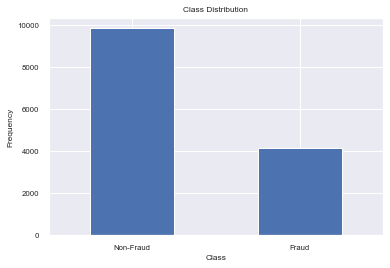

In [526]:
"""
The class distribution is strange. It's like 2:1, Non-Fraud:Fraud. 
This means we need to undersample.
"""
count_classes = pd.value_counts(df['FRAUD_NONFRAUD'], sort=True)
_ = count_classes.plot(kind='bar', rot=0)
_ = plt.title('Class Distribution')
_ = plt.xticks(range(2), ['Non-Fraud', 'Fraud'])
_ = plt.xlabel("Class")
_ = plt.ylabel("Frequency")

In [527]:
"""Encoding 0 for Fraud, 1 for Non-Fraud"""
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

def step1(df):
    le = LabelEncoder()
    df['FRAUD_NONFRAUD'] = le.fit_transform(df['FRAUD_NONFRAUD'])
    return df
df = step1(df)

In [528]:
"""Get the fraud and normal dataset"""
fraud = df[df['FRAUD_NONFRAUD']==0]
normal = df[df['FRAUD_NONFRAUD']==1]
print(fraud.shape,normal.shape)

(4164, 24) (9836, 24)


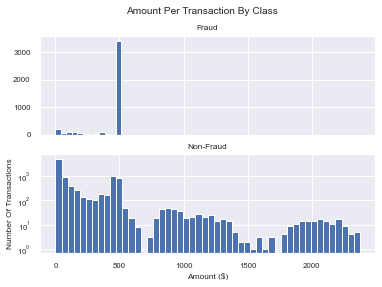

In [529]:
"""
2. The distribution of distributed amounts is different. Seems like fraudulant transfers are 
typically smaller quantities but mainly 500$. This is an interesting discovery. 
"""
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount Per Transaction By Class')
ax1.hist(fraud.TRAN_AMT, bins=50)
ax1.set_title('Fraud')
ax2.hist(normal.TRAN_AMT, bins=50)
ax2.set_title('Non-Fraud')
plt.xlabel('Amount ($)')
plt.ylabel('Number Of Transactions')
plt.yscale('log')
plt.show()

## Pre-Processing and continued EDA...
___
1. balance classes by undersampling 
2. convert datetime columns into multiple numerical columns 
3. label encode text based columns (ones that are useful to encode ofc)

In [530]:
"""
We know there is a class imbalance so we'd like to trim down the majority class using
undersampling. I think there are libraries like imblearn that do this but this is also 
sufficient.
"""
def step2(df):
    zeros_subset = df.loc[df['FRAUD_NONFRAUD']==0, :]
    num_zeros = len(zeros_subset)
    ones_subset = df.loc[df['FRAUD_NONFRAUD']==1, :]
    sampled_ones = ones_subset.sample(num_zeros)
    df = pd.concat([zeros_subset, sampled_ones], ignore_index=True)
    return df
df = step2(df)
df.groupby('FRAUD_NONFRAUD').count()

,TRAN_AMT,ACCT_PRE_TRAN_AVAIL_BAL,CUST_AGE,OPEN_ACCT_CT,WF_dvc_age,PWD_UPDT_TS,CARR_NAME,RGN_NAME,STATE_PRVNC_TXT,ALERT_TRGR_CD,...,CUST_ZIP,CUST_STATE,PH_NUM_UPDT_TS,CUST_SINCE_DT,TRAN_TS,TRAN_DT,ACTN_CD,ACTN_INTNL_TXT,TRAN_TYPE_CD,ACTVY_DT
FRAUD_NONFRAUD,,,,,,,,,,,,,,,,,,,,,
0,4164,4164,4164,4164,4164,3628,2195,2195,2195,4164,...,4164,4164,2816,4164,4164,4164,4164,4164,4164,4164
1,4164,4164,4164,4164,4164,3074,3842,3842,3842,4164,...,4164,4149,1732,4164,4164,4164,4164,4164,4164,4164


In [531]:
"""
Making features out of datetime objects. This is done by splitting datetiem objects into 
multiple compoenents. For example the date time 1996/1/6 0:0:0 will be split into six columns 
col1_year, col1_day, col1_month ... which will be a numerical column that can be dealt with where 
normal datetime objects could not be. 
NOTE: Dates that are invalid will recieve the impossible datetime of 1800/1/1 0:0:0
"""
from datetime import datetime
        
def convert_datetime_to_columns(df, col_name):
    df[f'{col_name}_year'] = df[col_name].dt.year
    df[f'{col_name}_month'] = df[col_name].dt.month
    df[f'{col_name}_day'] = df[col_name].dt.day
    df[f'{col_name}_hour'] = df[col_name].dt.hour
    df[f'{col_name}_min'] = df[col_name].dt.minute
    df[f'{col_name}_sec'] = df[col_name].dt.second
    
    
def step3(df):
    datetimes_to_split = ['CUST_SINCE_DT', 'TRAN_TS']
    for dt in datetimes_to_split:
        df[dt] = pd.to_datetime(df[dt]) # poof
        convert_datetime_to_columns(df, dt)

    incomplete_cols = ['PH_NUM_UPDT_TS','PWD_UPDT_TS']

    # dealing with the weird dates and replacing null values with impossible values
    for dt in incomplete_cols:
        df[dt] = df[dt].fillna('1/1/1800 0:0:0')
        for i, val in enumerate(df[dt]):
            try:
                df[dt].values[i] = datetime.strptime(df[dt].values[i], '%m/%d/%Y %H:%M:%S')
            except:
                df[dt].values[i] = datetime.strptime('1/1/1800 0:0:0', '%m/%d/%Y %H:%M:%S')
        df[dt] = pd.to_datetime(df[dt])
        convert_datetime_to_columns(df, dt)

    redundant_dates = ['TRAN_DT', 'ACTVY_DT','PH_NUM_UPDT_TS','PWD_UPDT_TS','CUST_SINCE_DT', 'TRAN_TS']
    df = df.drop(redundant_dates, axis=1) # dropping columns that seem to 
        # be just repeats of dates from tran_ts 
    return df
df = step3(df)

In [532]:
"""
There are quite a few text columns that could contain useful data, so i label encoded them 
so that they have a numerical value. These columsn have a lot of repeated values so I figured that this 
would allow me to encode them well and consistently. 
"""
def step4(df):
    deal_with = ['RGN_NAME', 'CARR_NAME', 'STATE_PRVNC_TXT', 'DVC_TYPE_TXT','ALERT_TRGR_CD']
    df[deal_with] = df[deal_with].fillna('None')
    for col in deal_with:
        df[col] = le.fit_transform(df[col])
#         df = pd.concat([df, pd.get_dummies(df[col], prefix=f'{col}')])
#         df = df.drop(col, axis=1)
    return df
df = step4(df)
df.head()

,TRAN_AMT,ACCT_PRE_TRAN_AVAIL_BAL,CUST_AGE,OPEN_ACCT_CT,WF_dvc_age,CARR_NAME,RGN_NAME,STATE_PRVNC_TXT,ALERT_TRGR_CD,DVC_TYPE_TXT,...,PH_NUM_UPDT_TS_day,PH_NUM_UPDT_TS_hour,PH_NUM_UPDT_TS_min,PH_NUM_UPDT_TS_sec,PWD_UPDT_TS_year,PWD_UPDT_TS_month,PWD_UPDT_TS_day,PWD_UPDT_TS_hour,PWD_UPDT_TS_min,PWD_UPDT_TS_sec
0,54.84,34570.63,36,8,1531,407,5,94,1,0,...,5,1,8,39,2021,12,22,10,42,51
1,497.08,12725.18,81,2,1095,70,11,91,0,1,...,8,10,27,6,2020,12,28,12,12,44
2,488.55,2851.44,45,8,1,393,14,11,1,1,...,18,9,50,5,2021,3,15,15,36,36
3,490.60,3018.98,55,7,531,90,14,11,0,2,...,16,16,50,5,2021,4,30,19,16,2
4,14.23,1890.65,72,4,276,3,0,0,1,2,...,12,10,54,10,2020,4,22,9,56,55


In [533]:
""" 
Columns that are inconsistent or no longer nessesary like dates (after they are broken up)
can be dropped. 
We are further label encoding other columns. 
NOTE: At this point all null records should be filled with something consistent in that column
"""
def step5(df):
    # dropping 
    drop = ['TRAN_TYPE_CD', 'ACTN_INTNL_TXT', 'ACTN_CD']
    df = df.drop(drop, axis=1)

    # label encodeing 
    encode_columns = ['CUST_STATE','AUTHC_PRIM_TYPE_CD','ALERT_TRGR_CD','AUTHC_SCNDRY_STAT_TXT', 'ALERT_TRGR_CD']
    for col in encode_columns:
        df[col] = le.fit_transform(df[col])

    df = df.dropna()
    return df
df = step6(df)


<AxesSubplot:>

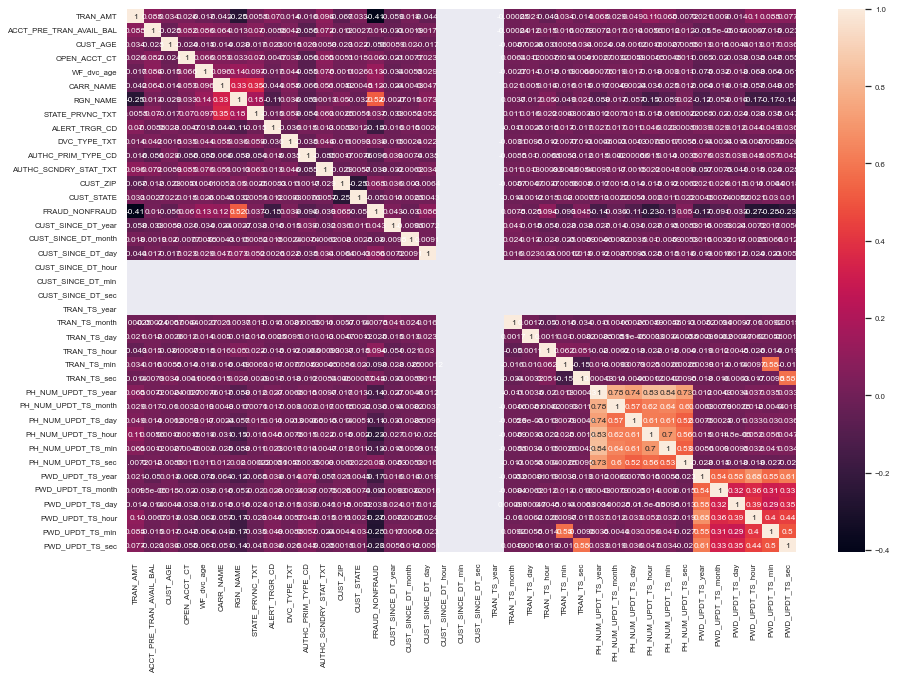

In [534]:
import seaborn as sns 
"""
There is some interesting correlation in the top left between FRAUD_NONFRAUD:RGN_NAME
and some others. Bottom right is as expected since they are a part of the same original feature.
"""
plt.figure(figsize=(15, 10))
sns.heatmap(df.corr(), annot=True)

In [535]:
"""
List of features that we want in the feature vector. 
"""
keep = list(df.columns)
keep.remove('FRAUD_NONFRAUD')
print(a)

['TRAN_AMT', 'ACCT_PRE_TRAN_AVAIL_BAL', 'CUST_AGE', 'OPEN_ACCT_CT', 'WF_dvc_age', 'ALERT_TRGR_CD', 'AUTHC_PRIM_TYPE_CD', 'AUTHC_SCNDRY_STAT_TXT', 'CUST_ZIP', 'CUST_STATE', 'CUST_SINCE_DT_year', 'CUST_SINCE_DT_month', 'CUST_SINCE_DT_day', 'CUST_SINCE_DT_hour', 'CUST_SINCE_DT_min', 'CUST_SINCE_DT_sec', 'TRAN_TS_year', 'TRAN_TS_month', 'TRAN_TS_day', 'TRAN_TS_hour', 'TRAN_TS_min', 'TRAN_TS_sec', 'ACTVY_DT_year', 'ACTVY_DT_month', 'ACTVY_DT_day', 'ACTVY_DT_hour', 'ACTVY_DT_min', 'ACTVY_DT_sec', 'TRAN_DT_year', 'TRAN_DT_month', 'TRAN_DT_day', 'TRAN_DT_hour', 'TRAN_DT_min', 'TRAN_DT_sec']


# Model Testing, Building, And Tuning
___
1. Test Random forest 
    * This is always a good starting point because it doesn't require scaling 
2. Test Multi-Layer Perceptron
    * I was very confident about the performance of this
3. Test Support Vector Machines 
    * Wasn't sure about the performance of this model
4. Test XGBoost 
    * I was very confident about the performance of this model provided that Random Forest performed well
5. Test Isolation Forest
    * I did test this method but it performed so poorly that I removed it. I think this would work bettter in a situation where there were way fewer instances of minority class. 
___
### How Models are evaluated:
1. Models have their classification report printed as well as their confusion matrix
2. Their roc and precision recall curves are plotted
3. Their roc-auc and auc of precisiion recall are both reported

In [536]:
"""
The below functions are for plotting the roc and precision-recall curves 
"""
from sklearn.metrics import roc_curve, precision_recall_curve, auc, f1_score
def plot_roc_curve(probs, y_test, model):
    ns_probs = [0 for _ in range(len(y_test))]
    lr_probs = probs[:, 1] # keep only probabilities for positive case 
    ns_auc = roc_auc_score(y_test, ns_probs)
    lr_auc = roc_auc_score(y_test, lr_probs)
    # get the curve data
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
    # plot the roc curve for the model
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(lr_fpr, lr_tpr, marker='.', label=model)
    # axis labels
    plt.title(f'Roc Curve {model}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

def plot_precicion_recall_curve(probs, pred,  y_test, model):
    lr_probs = probs[:, 1]
    lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
    lr_f1, lr_auc = f1_score(y_test, pred), auc(lr_recall, lr_precision)
    no_skill = len(y_test[y_test==1]) / len(y_test)
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    plt.plot(lr_recall, lr_precision, marker='.', label=model)
    # axis labels
    plt.title(f'Precision Recall Curve {model}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()
# plot_roc_curve(probs, y_test, 'Random Forest')
# plot_precicion_recall_curve(probs, pred, y_test, 'Random Forest')

# Random Forest:
___
Random forest is my favorite classifier because it just works so well in so many situations! 

#### Model Tuning:
  * We will tune it using GridSearch using 3 cross-validation folds. The hyper paramiter space we are searching is limited to max_depth, min_samples_leaf, n_estimators, and warm_start.
  * Hyper-paramiter tuning is an important step in improving the performance of any algorithm 
    
#### Model Performance:
   * The model performed very well according to the classification report and confusion matrix shown below. F1 reaches 94 percent. 
   * The roc-auc = 0.9426777213542334 and roc curve is graphed below. 
   * The precision-recall auc = 0.9887193107036885 and the curve is graphed below. 

In [510]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
def random_forest_gridsearch(X_train, X_test, y_train, y_test):
    param_grid = {
        'max_depth': list(range(5,10)),
        'min_samples_leaf': [5,10,25],
        'n_estimators': [200,300],
        'warm_start':[True, False]
    }
    print('grid searhing ...')
    grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=3,scoring='f1', verbose=True, n_jobs=-1)
    grid.fit(X_train, y_train)
    print(grid.best_params_)
    return grid.best_params_
    
    
def random_forest(X_train, X_test, y_train, y_test, params):
    rf = RandomForestClassifier(**params)
    print('Fitting...')
    rf.fit(X_train, y_train)
    print('Done fitting...')
    pred = rf.predict(X_test)
    print(confusion_matrix(y_test, pred))
    print(classification_report(y_test, pred))
    print(f'ROC_AUC_SCORE: {roc_auc_score(y_test,pred)}')
    return rf.predict_proba(X_test), pred


X = df[keep]
y = df['FRAUD_NONFRAUD']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
params = random_forest_gridsearch(X_train, X_test, y_train, y_test)
#params = {'max_depth': 9, 'min_samples_leaf': 5, 'n_estimators': 300, 'warm_start': False}
probs, pred = random_forest(X_train, X_test, y_train, y_test, params)

grid searhing ...
Fitting 3 folds for each of 60 candidates, totalling 180 fits
{'max_depth': 9, 'min_samples_leaf': 5, 'n_estimators': 200, 'warm_start': False}
Fitting...
Done fitting...
[[1139   78]
 [  62 1220]]
              precision    recall  f1-score   support

           0       0.95      0.94      0.94      1217
           1       0.94      0.95      0.95      1282

    accuracy                           0.94      2499
   macro avg       0.94      0.94      0.94      2499
weighted avg       0.94      0.94      0.94      2499

ROC_AUC_SCORE: 0.943773017970842


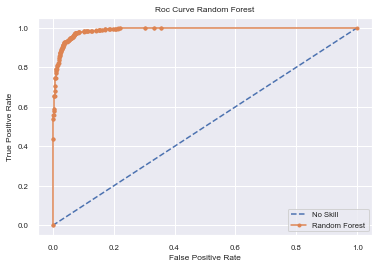

ROC_AUC_SCORE: 0.943773017970842


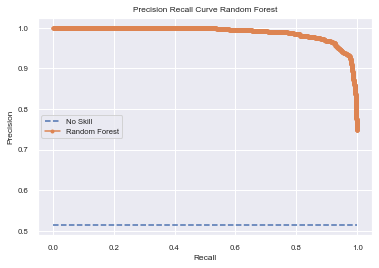

AUC_SCORE: 0.9885457930954745


In [511]:
plot_roc_curve(probs, y_test, 'Random Forest')
print(f'ROC_AUC_SCORE: {roc_auc_score(y_test,pred)}')
plot_precicion_recall_curve(probs, pred, y_test, 'Random Forest')
lr_probs = probs[:, 1]
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
print(f'AUC_SCORE: {auc(lr_recall, lr_precision)}')

# Multi-Layer Perceptron:
___
This model I have been curious about using for a while now and was not sure how well it would perform. I believe this model could perform better if the hyper paramiters were tuned more scrupulously, but that is just a suspicion.   

#### Model Tuning:
   * We will tune it using GridSearch using 3 cross-validation folds. The hyper paramiter space we are searching is limited to max_depth, min_samples_leaf, n_estimators, and warm_start.
   * Hyper-paramiter tuning is an important step in improving the performance of any algorithm 
#### Model Performance:
   * The model performed ok according to the classification report and confusion matrix shown below. F1 reaches 88 percent. 
   * The roc-auc = 0.8674720213195302 and roc curve is graphed below. 
   * The precision-recall auc = 0.9431482878013597 and the curve is graphed below.
   * **conclusion:** Random forest performed far better than this so this model is likely not optimal for the problem. I spent a lot of time tweeking the hyper paramiteres for this model and 88% f1 is the best I was able to get. 

In [347]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler 

def grid_neural_net(X_train, X_test, y_train, y_test):
    param_grid = {
    'hidden_layer_sizes': [(200,),(50,50,50), (50,100,50)],
    'activation': ['tanh'],
    'solver': ['adam'],
    'alpha': [ 0.10, 0.05, 0.001],
    'learning_rate': ['constant','adaptive'],
    'max_iter': [100,200,300,400,5000]
    }
    #----
    scaler = RobustScaler()
    scaler.fit(X_train)  
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    #----
    print('grid searhing ...')
    grid = GridSearchCV(MLPClassifier(), param_grid, cv=3, verbose=True, n_jobs=-1)
    grid.fit(X_train, y_train)
    print(grid.best_params_)
    return grid.best_params_

def neural_net(X_train, X_test, y_train, y_test, params):
    #----
    scaler = StandardScaler()
    scaler.fit(X_train)  
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    #----
    mlp = MLPClassifier()
    print('Fitting...')
    mlp.fit(X_train, y_train)
    print('Done fitting...')
    pred = mlp.predict(X_test)
    print(confusion_matrix(y_test, pred))
    print(classification_report(y_test, pred))
    return mlp.predict_proba(X_test), pred


X = df[keep]
y = df['FRAUD_NONFRAUD']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
# params = grid_neural_net(X_train, X_test, y_train, y_test)
params = {'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (200,), 'learning_rate': 'adaptive', 'max_iter': 200, 'solver': 'adam'}
probs, pred = neural_net(X_train, X_test, y_train, y_test, params)


Fitting...
Done fitting...
[[1063  171]
 [ 160 1105]]
              precision    recall  f1-score   support

           0       0.87      0.86      0.87      1234
           1       0.87      0.87      0.87      1265

    accuracy                           0.87      2499
   macro avg       0.87      0.87      0.87      2499
weighted avg       0.87      0.87      0.87      2499



/Users/benjaminpasternak/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


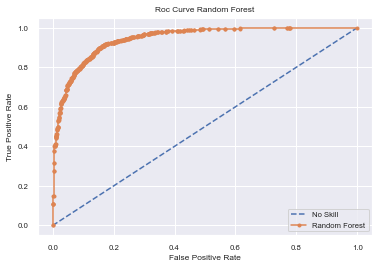

ROC_AUC_SCORE: 0.8674720213195302


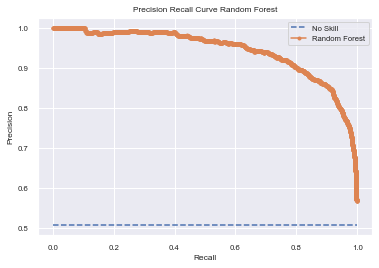

AUC_SCORE: 0.9431482878013597


In [348]:
plot_roc_curve(probs, y_test, 'Random Forest')
print(f'ROC_AUC_SCORE: {roc_auc_score(y_test,pred)}')
plot_precicion_recall_curve(probs, pred, y_test, 'Random Forest')
lr_probs = probs[:, 1]
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
print(f'AUC_SCORE: {auc(lr_recall, lr_precision)}')

# Support Vector Machine:
___
Support vector machines work well a lot of the time. It was an obvious model to check. It requires scaling the values in the dataset. For this I used Robust Scalar. It did not perform incredibly well.    

#### Model Tuning:
   * We will tune it using GridSearch using 3 cross-validation folds. The hyper paramiter space we are searching is limited to max_depth, min_samples_leaf, n_estimators, and warm_start.
   * Hyper-paramiter tuning is an important step in improving the performance of any algorithm 
#### Model Performance:
   * The model performed ok according to the classification report and confusion matrix shown below. F1 reaches 87 percent. 
   * The roc-auc = 0.8739724448031361 and roc curve is graphed below. 
   * The precision-recall auc = 0.9546972823529708 and the curve is graphed below.
   * **conclusion:** Svc performs worse, by the f1 accuracy measure, than mlp and random forest. It is therefore not the optimal algorithm for the task at hand. Perhaps a different scaling method should be used?  

In [467]:
from sklearn.svm import SVC

def grid_svc(X_train, X_test, y_train, y_test):
    param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01],
              'kernel': ['rbf']}
    #----
    scaler = RobustScaler()
    scaler.fit(X_train)  
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    #----
    print('grid searhing ...')
    grid = GridSearchCV(SVC(), param_grid, cv=3, scoring='f1',verbose=True, n_jobs=-1)
    grid.fit(X_train, y_train)
    print(grid.best_params_)
    return grid.best_params_

def svc(X_train, X_test, y_train, y_test, params):
    #----
    scaler = RobustScaler()
    scaler.fit(X_train)  
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    #----
    rf = SVC(**params)
    print('Fitting...')
    rf.fit(X_train, y_train)
    print('Done fitting...')
    pred = rf.predict(X_test)
    print(confusion_matrix(y_test, pred))
    print(classification_report(y_test, pred))
    return rf.predict_proba(X_test), pred


X = df[keep]
y = df['FRAUD_NONFRAUD']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
# params = grid_svc(X_train, X_test, y_train, y_test)
params = {'C': 10, 'gamma': 0.01, 'kernel': 'rbf', 'probability':True}
probs, pred = svc(X_train, X_test, y_train, y_test, params)

Fitting...
Done fitting...
[[1088  142]
 [ 158 1111]]
              precision    recall  f1-score   support

           0       0.87      0.88      0.88      1230
           1       0.89      0.88      0.88      1269

    accuracy                           0.88      2499
   macro avg       0.88      0.88      0.88      2499
weighted avg       0.88      0.88      0.88      2499



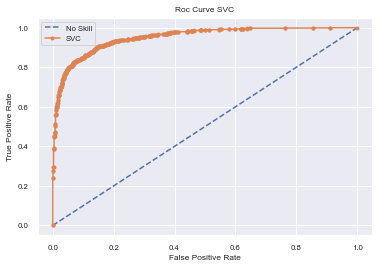

ROC_AUC_SCORE: 0.8739724448031361


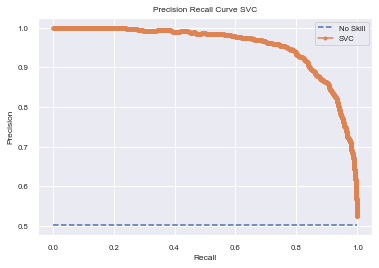

AUC_SCORE: 0.9546972823529708


In [351]:
plot_roc_curve(probs, y_test, 'SVC')
print(f'ROC_AUC_SCORE: {roc_auc_score(y_test,pred)}')
plot_precicion_recall_curve(probs, pred, y_test, 'SVC')
lr_probs = probs[:, 1]
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
print(f'AUC_SCORE: {auc(lr_recall, lr_precision)}')

# XGBoost:
___
In my expereince, in situations where Random forest performs well, XGBoost performs better. This is the case in this situation as well. XGBoost performed the best of any model I used.     

#### Model Tuning:
   * We will tune it using GridSearch using 3 cross-validation folds. The hyper paramiter space we are searching is limited to max_depth, min_samples_leaf, n_estimators, and warm_start.
   * Hyper-paramiter tuning is an important step in improving the performance of any algorithm 
#### Model Performance:
   * The model performed ok according to the classification report and confusion matrix shown below. F1 reaches 97 percent. 
   * The roc-auc = 0.9660119084982559 and roc curve is graphed below. 
   * The precision-recall auc = 0.9956882306446022 and the curve is graphed below.
   * **conclusion:** XGBoost certainly performs the best of any of the other algorithms. This algo was optomized for high f1.    

In [519]:
from xgboost import XGBClassifier

def grid_xgb(X_train, X_test, y_train, y_test):
    estimator = XGBClassifier(objective='binary:logistic', nthread=4, seed=42)
    param_grid = {
        'max_depth': list(range(7,10)),
        'n_estimators': [400,500,600,700],
        'learning_rate': [0.1,0.17,0.2,0.3, 0.35],
        'use_label_encoder': [False]
        }
    print('grid searhing ...')
    grid = GridSearchCV(estimator=estimator, param_grid=param_grid, scoring = 'f1',n_jobs = 10,cv = 3,verbose=True)
#     grid = GridSearchCV(XGBClassifier(), param_grid=param_grid, , cv=3, verbose=True, n_jobs=-1)
    grid.fit(X_train, y_train)
    print(grid.best_params_)
    return grid.best_params_

def xgb(X_train, X_test, y_train, y_test, params):
    rf = XGBClassifier(**params)
    print('Fitting...')
    rf.fit(X_train, y_train)
    print('Done fitting...')
    pred = rf.predict(X_test)
    print(confusion_matrix(y_test, pred))
    print(classification_report(y_test, pred))
    return rf.predict_proba(X_test), pred, rf


X = df[keep]
y = df['FRAUD_NONFRAUD']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
# params = grid_xgb(X_train, X_test, y_train, y_test)
params = {'learning_rate': 0.3, 'max_depth': 7, 'n_estimators': 600, 'use_label_encoder': False}
probs, pred, xgb_trained = xgb(X_train, X_test, y_train, y_test, params)

Fitting...
[19:09:42] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Done fitting...
[[1229   49]
 [  34 1187]]
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      1278
           1       0.96      0.97      0.97      1221

    accuracy                           0.97      2499
   macro avg       0.97      0.97      0.97      2499
weighted avg       0.97      0.97      0.97      2499



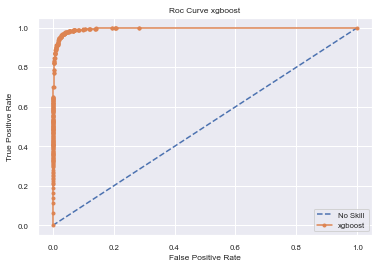

ROC_AUC_SCORE: 0.9669064070472521


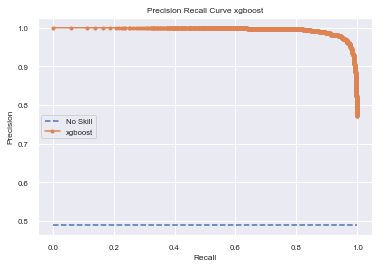

AUC_SCORE: 0.9947674136527391


In [520]:
plot_roc_curve(probs, y_test, 'xgboost')
print(f'ROC_AUC_SCORE: {roc_auc_score(y_test,pred)}')
plot_precicion_recall_curve(probs, pred, y_test, 'xgboost')
lr_probs = probs[:, 1]
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
print(f'AUC_SCORE: {auc(lr_recall, lr_precision)}')

# Outputting results:
___

In [537]:
df2 = pd.read_excel('../b765dc3d8076-testset_for_participants.xlsx')
df2.head()

,dataset_id,TRAN_AMT,ACCT_PRE_TRAN_AVAIL_BAL,CUST_AGE,OPEN_ACCT_CT,WF_dvc_age,PWD_UPDT_TS,CARR_NAME,RGN_NAME,STATE_PRVNC_TXT,...,CUST_ZIP,CUST_STATE,PH_NUM_UPDT_TS,CUST_SINCE_DT,TRAN_TS,TRAN_DT,ACTN_CD,ACTN_INTNL_TXT,TRAN_TYPE_CD,ACTVY_DT
0,1,54.25,0.0,23,4,634,9/18/2020 9:33:44,charter communications inc,southwest,california,...,55414,MN,7/8/2018 9:45:37,2011-02-19,1/8/2021 11:33:44,1/8/2021,SCHPMT,P2P_COMMIT,P2P,1/8/2021
1,2,110.30,0.0,56,3,1876,5/16/2021 17:2:31,comcast,mountain,colorado,...,77095,TX,NaN,2001-11-20,2/27/2021 7:2:31,2/27/2021,SCHPMT,P2P_COMMIT,P2P,2/27/2021
2,3,515.95,0.0,33,5,40,NaN,point broadband fiber holding llc,mid atlantic,virginia,...,94102,CA,8/28/2018 1:4:7,1999-10-17,4/22/2021 11:25:16,4/22/2021,SCHPMT,P2P_COMMIT,P2P,4/22/2021
3,4,42.78,0.0,60,3,367,2/18/2021 4:5:0,t-mobile usa inc.,southwest,california,...,93263,CA,7/3/2019 6:29:28,1998-07-03,6/17/2021 11:5:0,6/17/2021,SCHPMT,P2P_COMMIT,P2P,6/17/2021
4,5,0.01,0.0,61,12,518,2/18/2018 4:7:20,comcast cable communications llc,southwest,california,...,93313,CA,7/8/2020 11:45:37,2002-07-30,5/8/2021 10:0:51,5/8/2021,SCHPMT,P2P_COMMIT,P2P,5/8/2021


In [538]:
df2 = step3(df2)
df2 = step4(df2)
df2 = step5(df2)
keep = list(df2.columns)
keep.remove('dataset_id')
X = df2[keep]
pred = xgb_trained.predict(X)
# print(confusion_matrix(y_test, pred))
# print(classification_report(y_test, pred))
# return rf.predict_proba(X_test), pred
print(pred[:5])

[1 1 1 1 1]


In [539]:
count1 = 0
count0 = 0
for i in pred:
    if i == 1:
        count1+=1
    else:
        count0+=1
print(count1, count0)


4098 1902


In [540]:
ans_df = pd.DataFrame({'dataset_id': df2['dataset_id'].values, 'FRAUD_NONFRAUD': pred}, columns=['dataset_id','FRAUD_NONFRAUD'])
# print(pd.DataFrame(pred, columns=['FRAUD_NONFRAUD']).head())
# ans_df = pd.concat([pd.DataFrame(df2['dataset_id'], columns=['dataset_id']), pd.DataFrame(pred, columns=['FRAUD_NONFRAUD'])])
ans_df.head(20)

,dataset_id,FRAUD_NONFRAUD
0,1,1
1,2,1
2,3,1
3,4,1
4,5,1
5,6,1
6,7,0
7,8,0
8,9,0
9,10,1


In [541]:
ans_df.to_csv('../answer.csv', index=False)

In [515]:
! pip3 freeze > requirements.env